In [ ]:
#%run data_processing.ipynb

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

split dataframe into train and test

In [17]:
def split(one_hot_encoded_df, TEST_SET_RATIO):
    test_set_size = int(len(one_hot_encoded_df) * TEST_SET_RATIO)
    #print(test_set_size)
    #shuffle
    test_set_idx = np.random.choice(range(len(one_hot_encoded_df)), size=test_set_size, replace=False)
    test_set_idx = sorted(test_set_idx)
    #print("len of test set ids", len(test_set_idx))


    #split
    test_df = one_hot_encoded_df.iloc[test_set_idx]
    print("len of test set", len(test_df))
    train_df = one_hot_encoded_df.drop(one_hot_encoded_df.index[test_set_idx])
    
    X_train = train_df.iloc[:, :-1]


    y_train = train_df.iloc[:, -1].astype(str)

    X_test = test_df.iloc[:, :-1]

    y_test = test_df.iloc[:, -1].astype(str)
    
    return train_df,test_df, X_train, y_train, X_test, y_test

classification

In [18]:
def fit(X_train, y_train, method='fit'):
    logreg = LogisticRegression(random_state=0, solver='lbfgs',
                             multi_class='multinomial', max_iter=500).fit(X_train, y_train)
    return logreg

def predict(logreg, X):
    y_pred = logreg.predict(X)
    return y_pred.astype(str)

accuracy metrics functions

In [19]:
#jaccard similarity score
def jaccard_score(y_train, y_fitted, data_type='train'):
    print('Accuracy of logistic regression classifier on', data_type,' set: {:.2f}'
          .format(metrics.jaccard_similarity_score(y_train, y_fitted)))

In [24]:
bucket='sagemaker-training-02012019'
classif_filename = "debug/labeled_data_classification.csv" 
classif_loc = 's3://{}/{}'.format(bucket, classif_filename)

str_fields=['incident_id', 'target_topic', 'kb_id']
f_types={x:str for x in str_fields}

classif_df = pd.read_csv(classif_loc, dtype=f_types)

In [25]:
len(set(classif_df.target_topic))

12

In [26]:
#dropping unsused columns in the training
one_hot_encoded_df = classif_df.drop(columns=['customer_name', 'country_name', 'incident_severity',
       'year_create', 'month_create'])

In [23]:
'''
one_hot_encoded_df = pd.get_dummies(classif_df, columns=['customer_name', 'country_name', 'incident_severity',
       'year_create', 'month_create'])
cols = list(one_hot_encoded_df.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('target_topic')) #Remove target from list
one_hot_encoded_df = one_hot_encoded_df[cols+['target_topic']] #put back target in the end
'''

In [27]:
TEST_SET_RATIO = 0.1
print("the test set is ratio is", TEST_SET_RATIO)
train, test, X_train, y_train, X_test, y_test = split(one_hot_encoded_df, TEST_SET_RATIO)

the test set is ratio is 0.1
len of test set 189


In [28]:
#number of classes
print("number of classes after the splitting and shuffling")
print("for the train labels",len(set(y_train)))
print("for the test labels", len(set(y_test)))

number of classes after the splitting and shuffling
for the train labels 12
for the test labels 11


In [29]:
logreg = fit(X_train, y_train)
y_fitted = predict(logreg, X_train)

In [30]:
jaccard_score(y_train, y_fitted)

Accuracy of logistic regression classifier on train  set: 0.79


In [31]:
y_pred = predict(logreg, X_test)
jaccard_score(y_test, y_pred, 'test')

Accuracy of logistic regression classifier on test  set: 0.67


In [32]:
pred_class_intersection = np.intersect1d(logreg.classes_, y_pred)

In [33]:
conf = metrics.confusion_matrix(y_test.astype(str), y_pred.astype(str), labels=logreg.classes_)

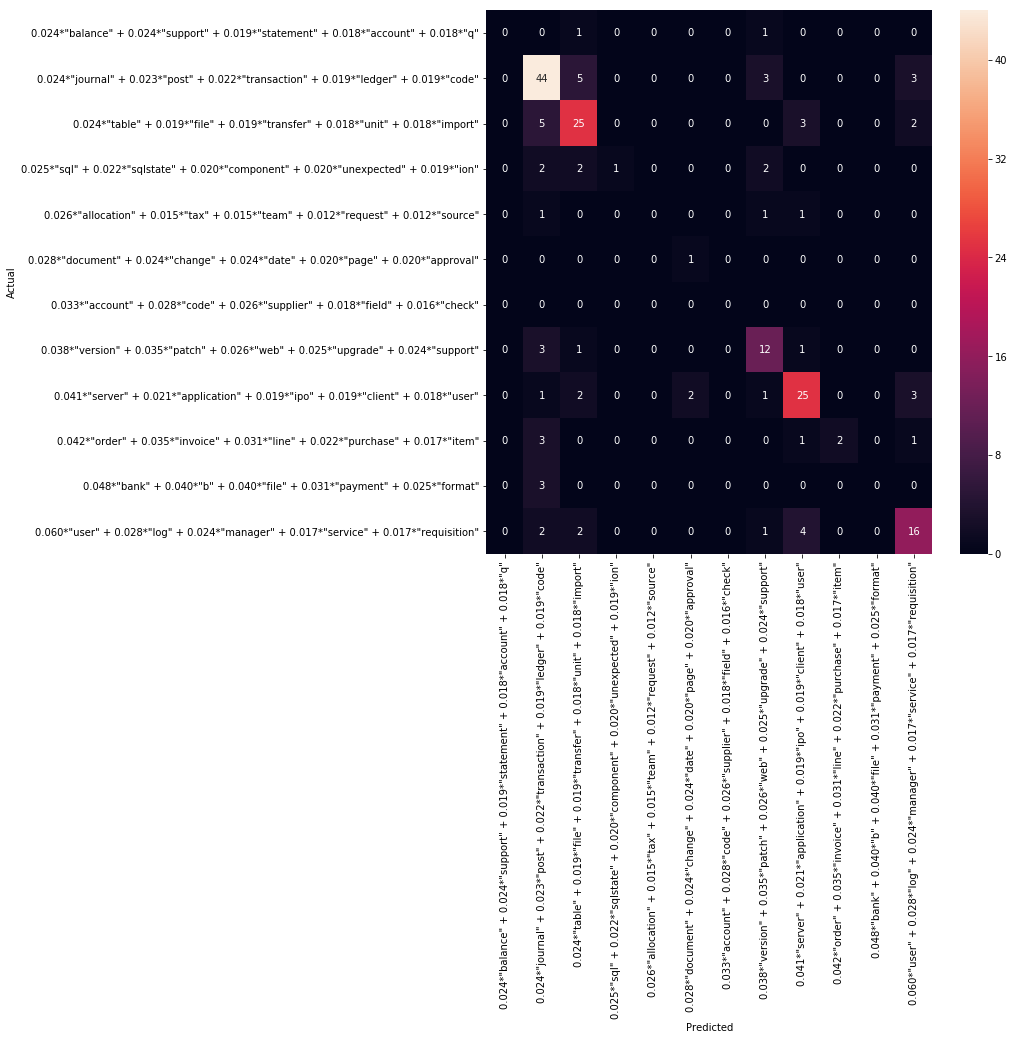

In [34]:

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf, annot=True, fmt='d',
            xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


F1 = 2 * (precision * recall) / (precision + recall)

In [ ]:

pred_class_intersection = np.intersect1d(logreg.classes_, y_pred)
f1 = metrics.f1_score(y_test, y_pred, average='weighted', labels=pred_class_intersection)
f1

In [ ]:
metrics.precision_score(y_test, y_pred, labels=pred_class_intersection, average='weighted')

In [ ]:
metrics.recall_score(y_test, y_pred, labels=pred_class_intersection, average='weighted')

In [ ]:
train['fitted_values'] = y_fitted
test['prediction'] = y_pred
datafr = pd.concat([train[['incident_id', 'fitted_values']], 
                    test[['incident_id', 'prediction', 'target_topic']]])

In [ ]:
load_col=['incident_id', 'customer_name', 'country_name', 'product_name', 'year_create', 'month_create',
          'incident_description', 'kb_title']
col_types={x:str for x in load_col}
#put under debug the prediction report and download the data from s3
full_data = pd.read_csv('data/full_labeled_data.csv', usecols=load_col, dtype=col_types)
datafr['incident_id']= datafr['incident_id'].astype('str')
full_data['incident_id']= full_data['incident_id'].astype('str')

In [ ]:
report = pd.merge(full_data, datafr, on='incident_id', how='inner').drop_duplicates()
#put under debug the prediction report 
report.to_csv('data/predictions_report.csv', index=False)

In [ ]:
#wordcloud visualization and EDA
#from subprocess import call
#call("pip install wordcloud".split(" "))

In [ ]:
#import matplotlib.pyplot as plt
#from wordcloud import WordCloud, ImageColorGenerator

In [ ]:
'''
def wordcloud_kb(df, idx):
    incident_desc = report['incident_description'][idx]
    wc = WordCloud( max_font_size=50, max_words=100, background_color="white").generate(incident_desc)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print("the incident description is:\n", incident_desc, "\n")
    print("the related kb title is:\n", report['kb_title'][idx])
    print("the prediction is:\n", report['prediction'][idx])
    print("the actual is:\n", report['target_topic'][idx])
'''